In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from scipy.stats import pearsonr

In [2]:

import os
import sys
# Get the absolute path to the src directory
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
parent_dir = os.path.dirname(src_path)
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [3]:
def load_news_data(file_path: str) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    df = df[['date', 'stock', 'headline']].copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce').dt.tz_localize(None)
    df['date'] = df['date'].dt.normalize()
    df['sentiment'] = df['headline'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [4]:
def get_daily_sentiment(news_df: pd.DataFrame, ticker: str) -> pd.DataFrame:
    df = news_df[news_df['stock'] == ticker]
    daily_sentiment = df.groupby('date')['sentiment'].mean().reset_index()
    daily_sentiment.rename(columns={'date': 'Date', 'sentiment': 'Sentiment'}, inplace=True)
    return daily_sentiment

In [5]:
def load_stock_data(filepath: str) -> pd.DataFrame:
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce').dt.tz_localize(None)
    df.sort_values('Date', inplace=True)
    return df

In [6]:
def compute_daily_returns(df: pd.DataFrame) -> pd.DataFrame:
    df['Return'] = df['Close'].pct_change()
    return df[['Date', 'Return']]


In [7]:
def merge_sentiment_and_returns(sentiment_df: pd.DataFrame, returns_df: pd.DataFrame) -> pd.DataFrame:
    merged = pd.merge(sentiment_df, returns_df, on='Date', how='inner')
    return merged

In [8]:
def compute_correlation(merged_df: pd.DataFrame) -> float:
    if len(merged_df) < 2:
        return None
    corr, _ = pearsonr(merged_df['Sentiment'], merged_df['Return'])
    return corr

In [9]:
def plot_sentiment_vs_return(df: pd.DataFrame, ticker: str):
    plt.figure(figsize=(8, 6))
    sns.regplot(x='Sentiment', y='Return', data=df, scatter_kws={'alpha':0.5})
    plt.title(f"Sentiment vs Return for {ticker}")
    plt.xlabel("Daily Sentiment Score")
    plt.ylabel("Daily Return (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [10]:
def analyze_news_stock_correlation(news_path: str, tickers: list, stock_folder: str):
    news_df = load_news_data(news_path)
    results = {}

    for ticker in tickers:
        print(f"\n📊 Processing: {ticker}")
        stock_path = f'{stock_folder}/{ticker}_historical_data.csv'
        stock_df = load_stock_data(stock_path)
        stock_returns = compute_daily_returns(stock_df)
        sentiment_df = get_daily_sentiment(news_df, ticker)
        merged_df = merge_sentiment_and_returns(sentiment_df, stock_returns)
        correlation = compute_correlation(merged_df)
        
        results[ticker] = {
            'Correlation': correlation,
            'Merged Data': merged_df
        }

        if correlation is not None:
            print(f"✅ Correlation for {ticker}: {correlation:.4f}")
            plot_sentiment_vs_return(merged_df, ticker)
        else:
            print(f"⚠️ Insufficient data for {ticker} correlation plot")

    return results


📊 Processing: AAPL
✅ Correlation for AAPL: -1.0000


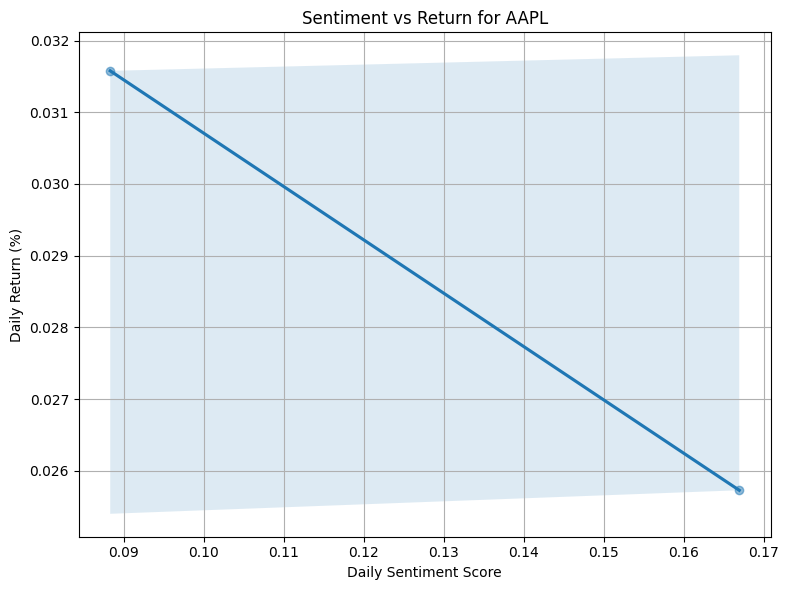


📊 Processing: AMZN
✅ Correlation for AMZN: -1.0000


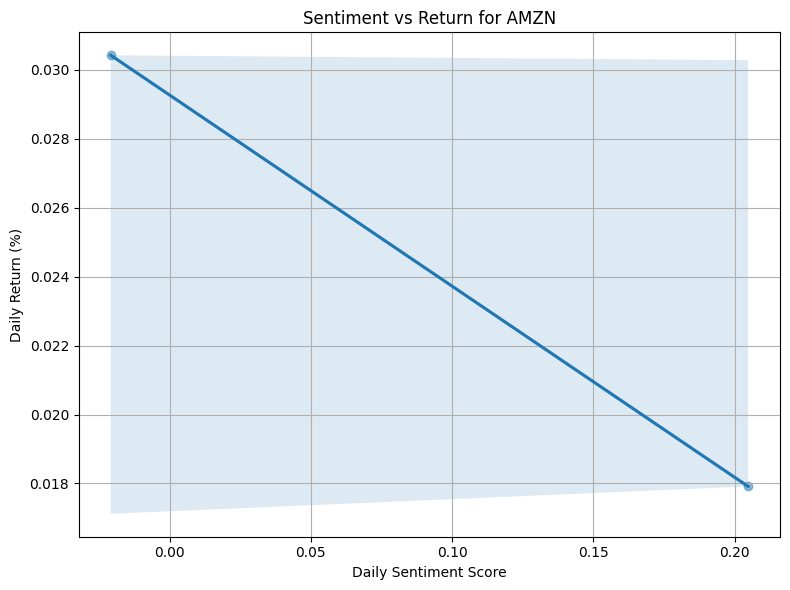


📊 Processing: GOOG
✅ Correlation for GOOG: -0.0894


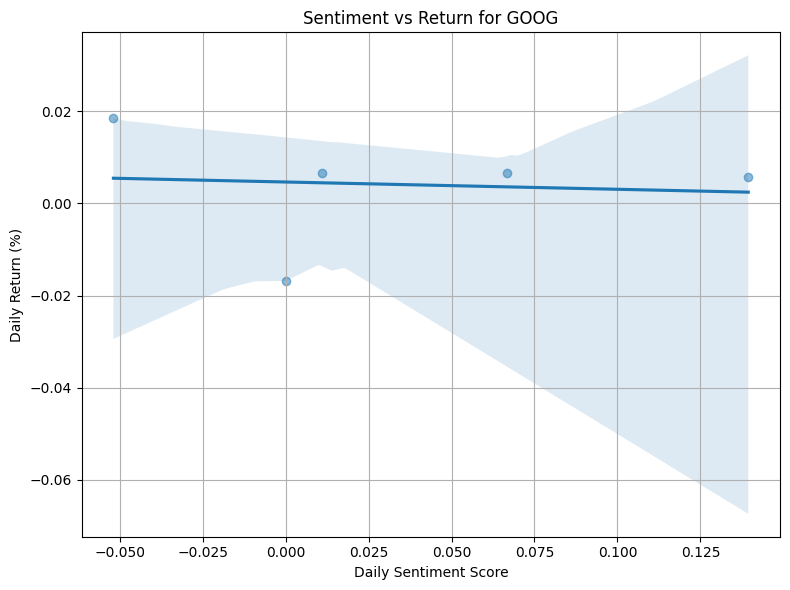


📊 Processing: META
⚠️ Insufficient data for META correlation plot

📊 Processing: MSFT
⚠️ Insufficient data for MSFT correlation plot

📊 Processing: NVDA
✅ Correlation for NVDA: 0.1757


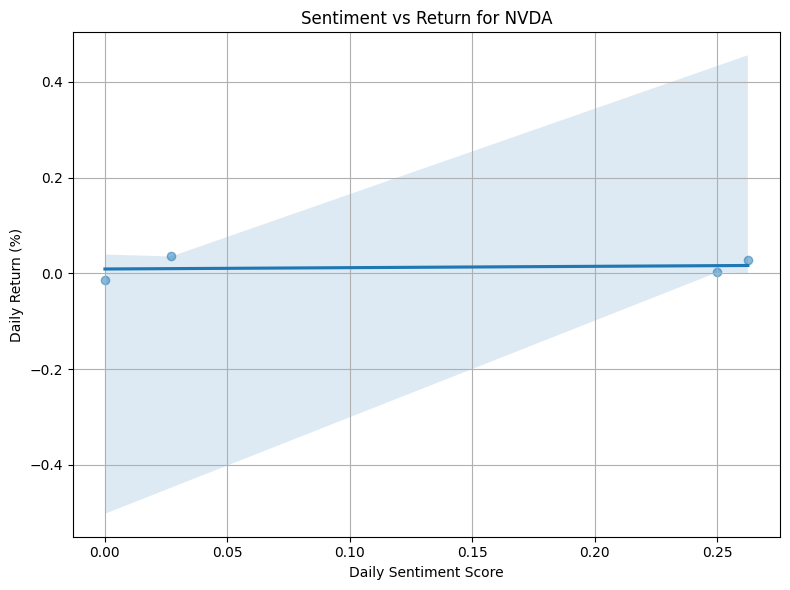


📊 Processing: TSLA
⚠️ Insufficient data for TSLA correlation plot


In [11]:
news_path = '../data/raw_analyst_ratings.csv/raw_analyst_ratings.csv'
tickers = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
stock_folder = '../data/yfinance_data'
results = analyze_news_stock_correlation(news_path, tickers, stock_folder)

In [12]:
DataFrame = load_news_data(news_path)
DataFrame.head()

,date,stock,headline,sentiment
0,2020-06-05,A,Stocks That Hit 52-Week Highs On Friday,0.0
1,2020-06-03,A,Stocks That Hit 52-Week Highs On Wednesday,0.0
2,2020-05-26,A,71 Biggest Movers From Friday,0.0
3,2020-05-22,A,46 Stocks Moving In Friday's Mid-Day Session,0.0
4,2020-05-22,A,B of A Securities Maintains Neutral on Agilent...,0.0
